In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
donors_csv = f"./output/donors_agg_pred_lastname_trunc.csv"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,name_new,orgname,realcode,gender,occupation,city,state,total_donated,donation_count,avg_donation,med_donation,combined_ratio,indian,cycle,sector
0,1,ampac ampac,[24I Contribution],Z9500,,NaN,WASHINGTON,DC,379351224.0,30966,12250.572370,1000.0,0.000000,False,2000,Party
1,,,[Candidate Contribution],Y4000,,NaN,NaN,,144446528.0,19266,7497.484065,300.0,0.000000,False,2000,Unknown
2,a0000305213,steve forbes,[Candidate Contribution],Z9000,M,NaN,NaN,,7050000.0,11,640909.090909,750000.0,0.016339,False,2000,Party
3,U00000003381,s daniel abraham,Slim-Fast Foods,H4600,M,NaN,WEST PALM BEACH,FL,1615500.0,53,30481.132075,1000.0,0.248928,False,2000,Health
4,U00000002531,bernard l schwartz,Loral Space & Communications,C4400,M,NaN,NEW YORK,NY,1355000.0,44,30795.454545,20000.0,0.000000,False,2000,Tech
5,U00000002811,peter l buttenwieser,Peter L Buttenwieser & Assoc,J1200,M,NaN,PHILADELPHIA,PA,1307700.0,63,20757.142857,5000.0,0.000000,False,2000,Ideology/Single Issue
6,U00000003801,haim saban,Saban Entertainment,C2400,M,NaN,LOS ANGELES,CA,1250000.0,39,32051.282051,1000.0,0.340212,False,2000,Tech
7,U00000000041,carl h lindner,American Financial Group,F3100,M,NaN,CINCINNATI,OH,1187490.0,52,22836.346154,1000.0,0.000000,False,2000,Finance
8,U00000041441,davidi gilo,Vyyo Inc,C4600,N,NaN,WOODSIDE,CA,1144500.0,22,52022.727273,1000.0,0.880770,False,2000,Tech
9,U0000004191,constance milstein,Milstein Properties,F4500,F,NaN,NEW YORK,NY,959515.0,32,29984.843750,4257.5,0.002620,False,2000,Finance


In [4]:
donors[donors["indian"] == True].sort_values(by="total_donated", ascending=False).head(10)

,contrib_id,name_new,orgname,realcode,gender,occupation,city,state,total_donated,donation_count,avg_donation,med_donation,combined_ratio,indian,cycle,sector
15394789,U0000004761,nishad singh,FTX.US,F2800,M,DIRECTOR OF ENGINEERING,LOS ALTOS HILLS,CA,8476000.0,148,57270.270270,2900.0,32.637847,True,2022,Finance
7535179,U0000003169,philip munger,Investor,F7000,M,INVESTOR,NEW YORK,NY,4881929.0,325,15021.320000,2700.0,0.180377,True,2016,Finance
9971305,h3003465387,shiva ayyadurai,[Candidate Contribution],Z9000,M,CHAIRMAN & CEO,CAMBRIDGE,MA,4817653.0,39,123529.564103,3133.0,3.302889,True,2018,Party
11805965,U00000033011,vinod khosla,Khosla Ventures,F2500,M,VENTURE CAPITALIST,PORTOLA VALLEY,CA,2410795.0,56,43049.910714,2224.0,58.605447,True,2020,Finance
15394949,U00000033011,vinod khosla,Khosla Ventures,F2500,M,VENTURE CAPITALIST,PORTOLA VALLEY,CA,2084900.0,30,69496.666667,5000.0,58.605447,True,2022,Finance
7535269,U0000004128,charles t jr munger,SLAC National Accelerator Laboratory,X3000,M,PHYSICIST,PALO ALTO,CA,1888200.0,57,33126.315789,2700.0,0.112439,True,2016,NaN
7535284,U00000035581,muneer a satter,Satter Investment Management,F2600,M,PRIVATE INVESTOR,CHICAGO,IL,1739100.0,69,25204.347826,2700.0,0.428483,True,2016,Finance
11806080,m0001327150,sameer gandhi,Accel Partners,F2500,M,VENTURE CAPITALIST,SAN FRANCISCO,CA,1629499.0,110,14813.627273,10000.0,25.319363,True,2020,Finance
9971391,U0000003169,philip munger,Investor,F7000,M,INVESTOR,NEW YORK,NY,1628961.0,202,8064.163366,2700.0,0.180377,True,2018,Finance
7535314,U00000003781,amy joyce rao,Integrated Archive Systems,C5130,F,CEO,PALO ALTO,CA,1495229.0,567,2637.088183,200.0,8.309695,True,2016,Tech


In [5]:
population = pd.read_csv("./data/aapi_population.csv")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2014,Alabama,AL,11754,4841799,0.242761
1,2014,Alaska,AK,0,736283,0.000000
2,2014,Arizona,AZ,39764,6730413,0.590811
3,2014,Arkansas,AR,8035,2967392,0.270776
4,2014,California,CA,607297,38596972,1.573432
5,2014,Colorado,CO,20342,5350101,0.380217
6,2014,Connecticut,CT,49204,3594524,1.368860
7,2014,Delaware,DE,13349,932487,1.431548
8,2014,District of Columbia,DC,136461,662328,20.603236
9,2014,Florida,FL,130382,19845911,0.656972


In [6]:
state_stats = (
    donors[donors["cycle"] == 2000 + int(year)].groupby("state")
    .agg(
        total_donations=("total_donated", "sum"),
        mean_other=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == False].mean()),
        mean_indian=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == True].mean()),
        med_other=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == False].median()),
        med_indian=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == True].median()),
        sum_other=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == False].sum()),
        sum_indian=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == True].sum()),
        count_other=("indian", lambda x: (x == False).sum()),
        count_indian=("indian", lambda x: (x == True).sum())
    )
    .sort_values("total_donations", ascending=False)
    .reset_index()
)
state_stats.head(10)

,state,total_donations,mean_other,mean_indian,med_other,med_indian,sum_other,sum_indian,count_other,count_indian
0,CA,3.367424e+09,6234.913915,3683.399238,462.0,525.0,3.332605e+09,34819173.0,534507,9453
1,NY,2.086477e+09,8547.238937,3531.432880,488.0,550.0,2.072193e+09,14284646.0,242440,4045
2,TX,7.675790e+08,2911.931598,2630.661769,500.0,616.0,7.575536e+08,10025452.0,260155,3811
3,FL,7.071264e+08,3139.605055,4254.516146,407.0,500.0,6.989577e+08,8168671.0,222626,1920
4,IL,3.857802e+08,3058.642412,2668.091705,420.0,583.0,3.799904e+08,5789759.0,124235,2170
5,MA,3.450963e+08,3122.452462,4372.560172,500.0,500.0,3.389922e+08,6104094.0,108566,1396
6,VA,2.599457e+08,2200.802242,2720.284166,500.0,543.0,2.554273e+08,4518392.0,116061,1661
7,WA,2.502486e+08,2006.718130,3050.944138,387.0,500.0,2.463708e+08,3877750.0,122773,1271
8,PA,2.457529e+08,1833.446907,1893.772794,400.0,500.0,2.431774e+08,2575531.0,132634,1360
9,GA,2.429476e+08,2487.417052,1685.812812,500.0,500.0,2.409213e+08,2026347.0,96856,1202


In [7]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
state_df = gdf.merge(state_stats, on="state", how="left")
state_df = state_df.merge(population[population["Year"] == 2020], left_on="state", right_on="Code", how="left")
state_df.iloc[:2]

,iso_3166_2,name,geometry,state,total_donations,mean_other,mean_indian,med_other,med_indian,sum_other,sum_indian,count_other,count_indian,Year,Name,Code,Indian Pop,Census Pop,Share
0,US-MN,Minnesota,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",MN,120920958.0,1904.182910,1460.490698,365.0,370.5,120292947.0,628011.0,63173,430,2020,Minnesota,MN,45092,5710735,0.789601
1,US-MT,Montana,"POLYGON ((-116.04823 49.00037, -113.0595 49.00...",MT,30926678.0,2020.771069,3637.105263,500.0,500.0,30788468.0,138210.0,15236,38,2020,Montana,MT,756,1087230,0.069535


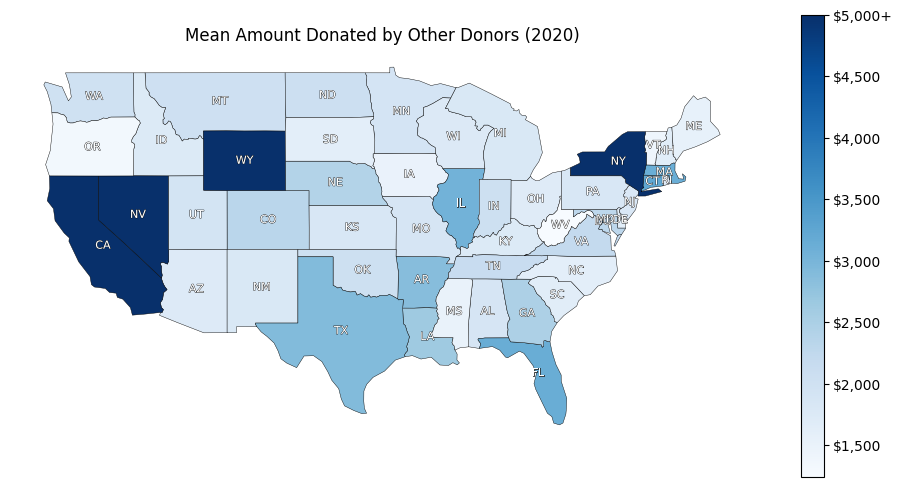

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
map = state_df.plot(
    column="mean_other",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=5000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"${int(tick):,}" if tick != 5000 else "$5,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Mean Amount Donated by Other Donors (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

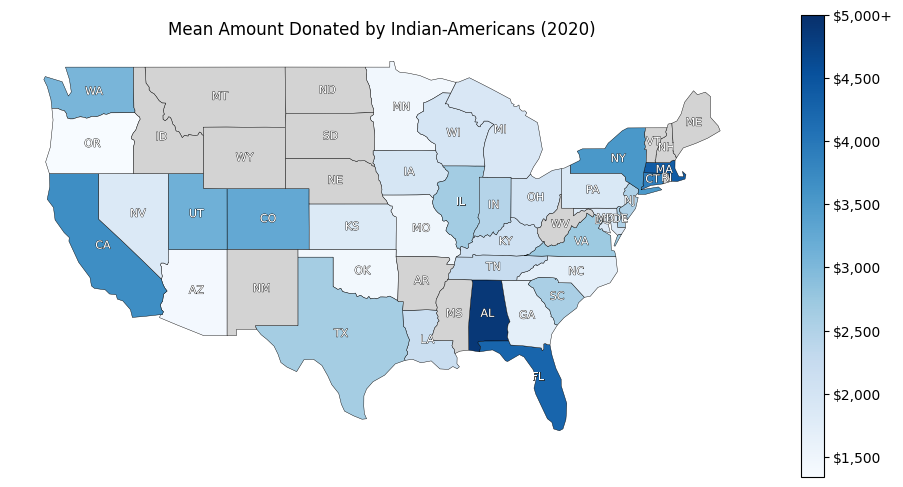

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_df.copy()
copy_df.loc[copy_df['sum_indian'] < 250000, 'mean_indian'] = np.nan

map = copy_df.plot(
    column="mean_indian",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=5000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"${int(tick):,}" if tick != 5000 else "$5,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Mean Amount Donated by Indian-Americans (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

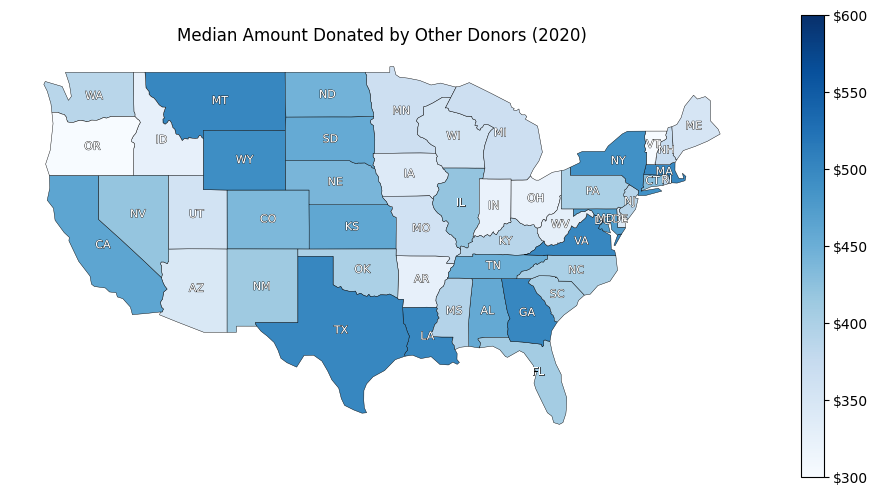

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
map = state_df.plot(
    column="med_other",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=600
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"${int(tick):,}" if tick != 5000 else "$5,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Median Amount Donated by Other Donors (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

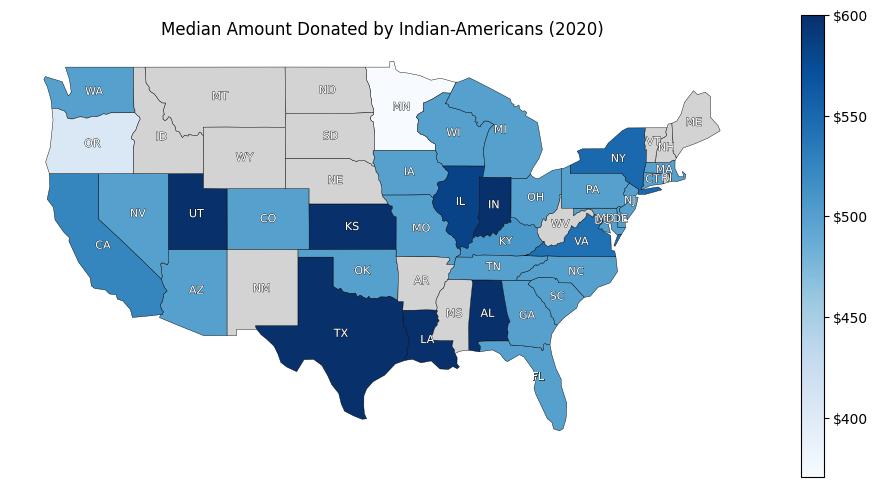

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_df.copy()
copy_df.loc[copy_df['sum_indian'] < 250000, 'med_indian'] = np.nan

map = copy_df.plot(
    column="med_indian",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=600
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"${int(tick):,}" if tick != 5000 else "$5,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Median Amount Donated by Indian-Americans (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [12]:
donors[(donors["cycle"] == 2020) & (donors["indian"] == True) & (donors["state"] == "IN")].iloc[:5]

,contrib_id,name_new,orgname,realcode,gender,occupation,city,state,total_donated,donation_count,avg_donation,med_donation,combined_ratio,indian,cycle,sector
11822567,U0000003736A,claire gagan,Retired,X1200,F,RETIRED,VALPARAISO,IN,50004.0,91,549.494505,250.0,20.900813,True,2020,NaN
11825493,b0608349608,bharat h barai,Premier Oncology Hematology Assoc,J7500,M,PHYSICIAN,MUNSTER,IN,43601.0,29,1503.482759,1000.0,36.992357,True,2020,Ideology/Single Issue
11828373,a00002496371,bharat barai,[24T Contribution],Z9500,M,MED DOCTOR,MUNSTER,IN,38581.0,28,1377.892857,1000.0,65.559332,True,2020,Party
11832996,i30039735121,rao polavarapu,Anthem Inc,H3700,M,IT ANALYST,RICHMOND,IN,32800.0,9,3644.444444,2800.0,15.292134,True,2020,Health
11837414,j1001839178,amish shah,Kem Krest,Y4000,M,PRESIDENT,BRISTOL,IN,28800.0,5,5760.000000,2800.0,6.228569,True,2020,Unknown


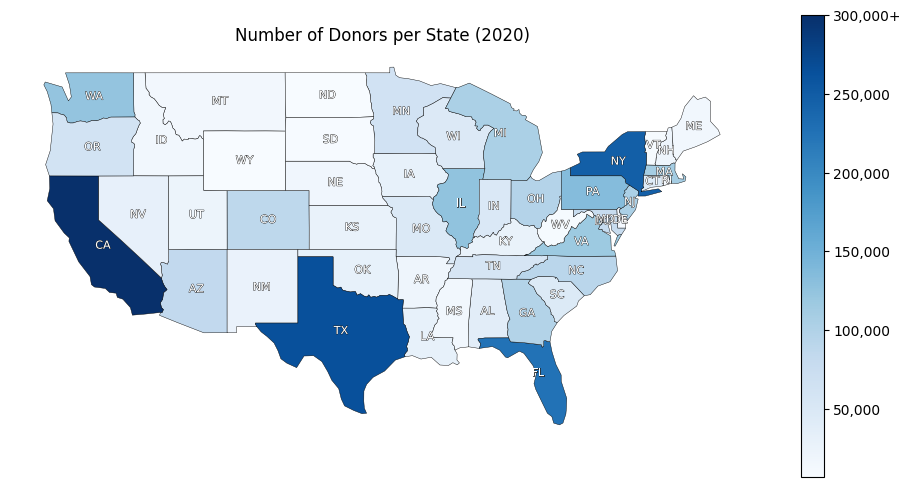

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_df.copy()
copy_df["count_total"] = copy_df["count_other"] + copy_df["count_indian"]

map = copy_df.plot(
    column="count_total",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=300000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"{int(tick):,}" if tick != 300000 else "300,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Number of Donors per State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

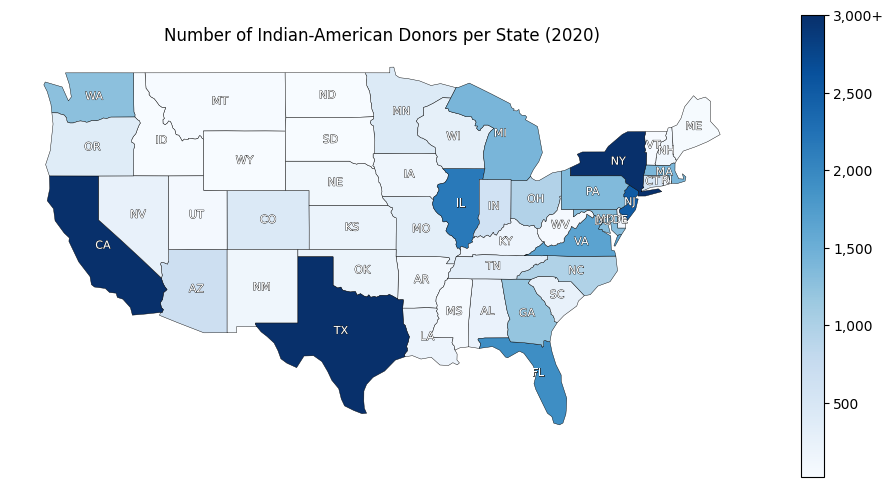

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

map = copy_df.plot(
    column="count_indian",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=3000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"{int(tick):,}" if tick != 3000 else "3,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Number of Indian-American Donors per State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [15]:
state_df[["state", "count_other", "count_indian", "Indian Pop"]].sort_values(by="count_indian", ascending=False).tail(10)

,state,count_other,count_indian,Indian Pop
11,UT,23300,87,12103
30,MS,16215,81,7060
40,WV,9950,61,3375
47,ME,16522,50,1844
26,VT,9868,39,1351
1,MT,15236,38,756
3,ID,16773,35,2948
19,SD,8398,30,1676
2,ND,6734,29,993
12,WY,7022,24,606


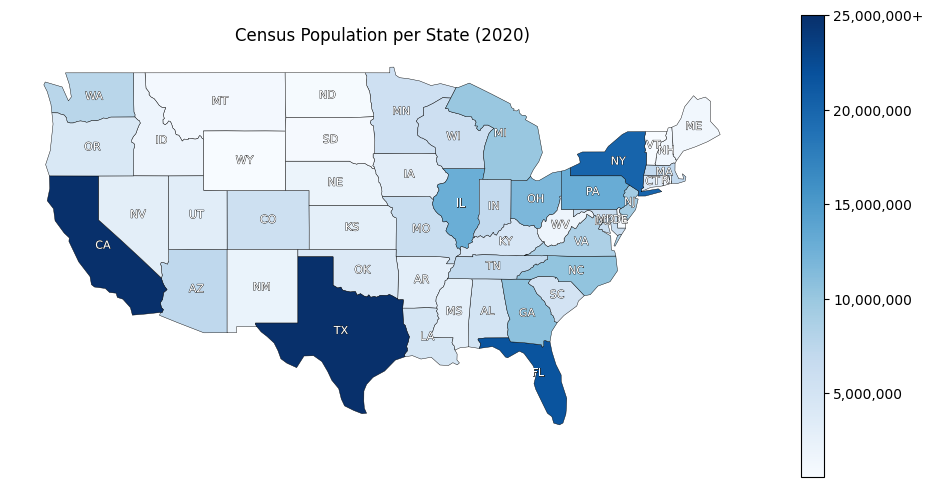

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

map = state_df.plot(
    column="Census Pop",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=25000000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"{int(tick):,}" if tick != 25000000 else "25,000,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Census Population per State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

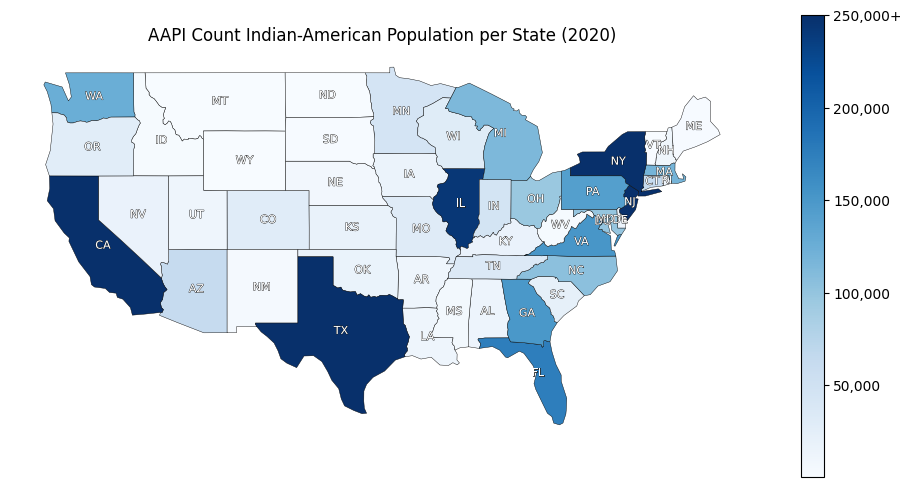

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

map = state_df.plot(
    column="Indian Pop",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=250000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"{int(tick):,}" if tick != 250000 else "250,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"AAPI Count Indian-American Population per State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

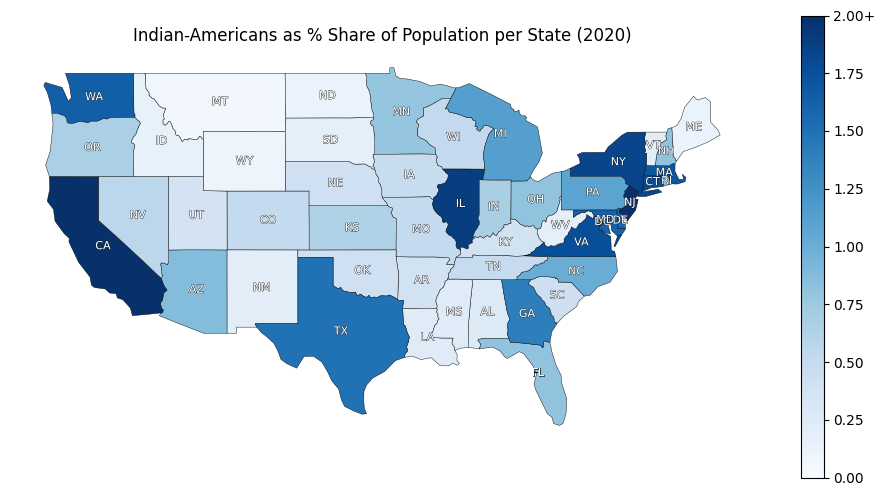

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

map = state_df.plot(
    column="Share",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=2
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"{tick:.2f}" if tick != 2 else "2.00+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Indian-Americans as % Share of Population per State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [19]:
state_df["count_pc"] = (state_df["count_other"] + state_df["count_indian"]) / state_df["Census Pop"] * 100
state_df["count_pc_indian"] = state_df["count_indian"] / state_df["Indian Pop"] * 100
state_df["count_pc_diff"] = state_df["count_pc_indian"] - state_df["count_pc"]
state_df["sum_pc"] = (state_df["sum_other"] + state_df["sum_indian"]) / state_df["Census Pop"] * 100
state_df["sum_pc_indian"] = state_df["sum_indian"] / state_df["Indian Pop"] * 100
state_df["sum_pc_diff"] = state_df["sum_pc_indian"] - state_df["sum_pc"]

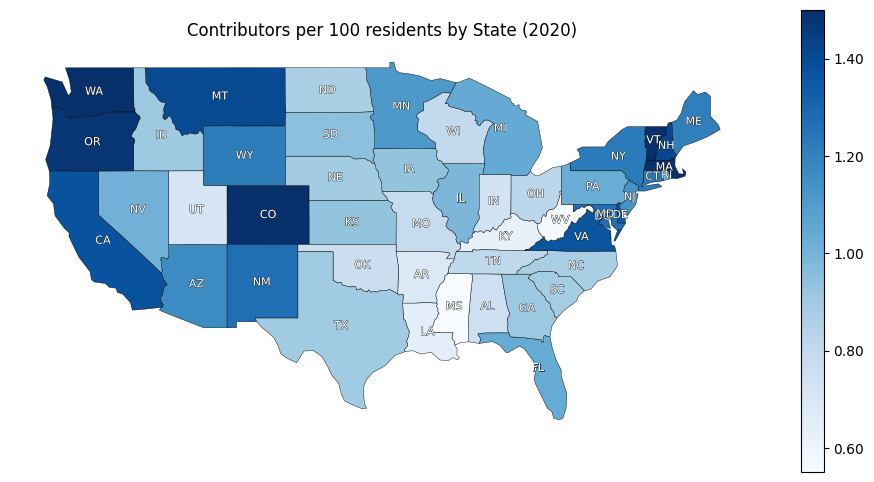

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))

map = state_df.plot(
    column="count_pc",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=1.5
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
# round ticks to two decimal places
tick_labels = [f"{tick:.2f}" if tick != 1.5 else "1.50+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Contributors per 100 residents by State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

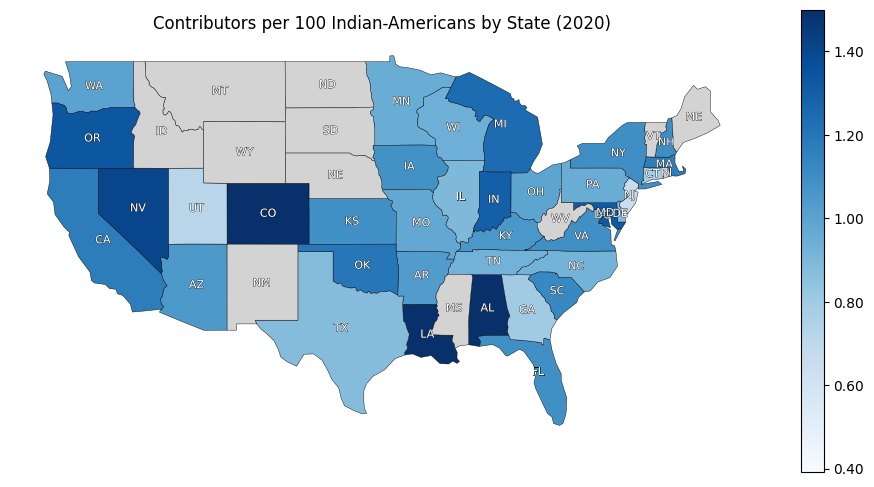

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_df.copy()
copy_df.loc[copy_df['Indian Pop'] < 10000, 'count_pc_indian'] = np.nan

map = copy_df.plot(
    column="count_pc_indian",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=1.5
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
# round ticks to two decimal places
tick_labels = [f"{tick:.2f}" if tick != 1.5 else "1.50+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Contributors per 100 Indian-Americans by State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

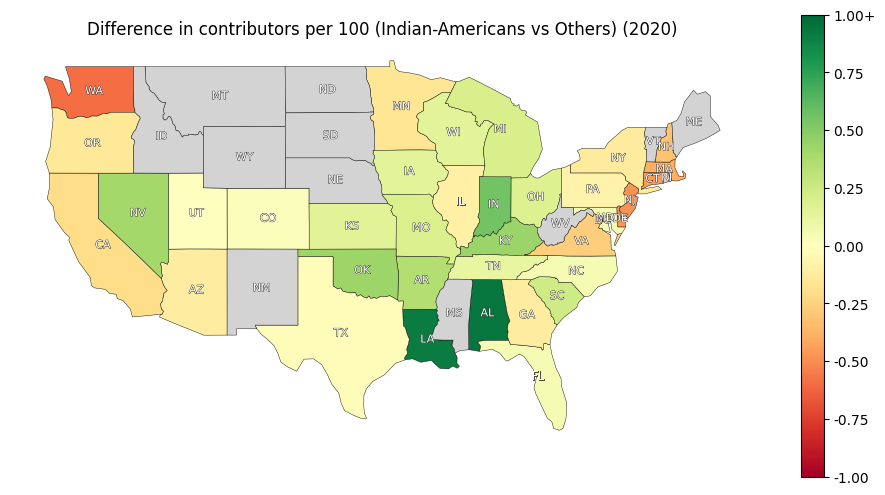

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_df.copy()
copy_df.loc[copy_df['Indian Pop'] < 10000, 'count_pc_diff'] = np.nan

map = copy_df.plot(
    column="count_pc_diff",
    cmap="RdYlGn",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=-1,
    vmax=1
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"{tick:.2f}" if tick != 1 else "1.00+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Difference in contributors per 100 (Indian-Americans vs Others) (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

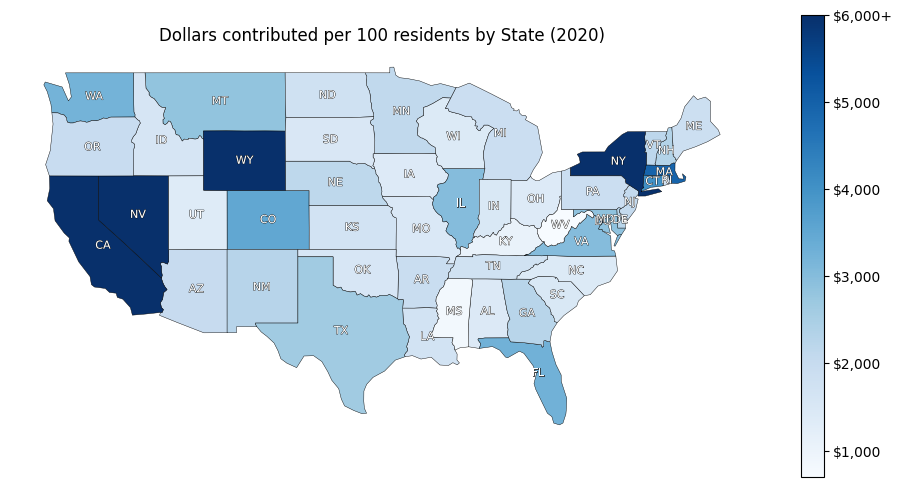

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

map = state_df.plot(
    column="sum_pc",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=6000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"${int(tick):,}" if tick != 6000 else "$6,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Dollars contributed per 100 residents by State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

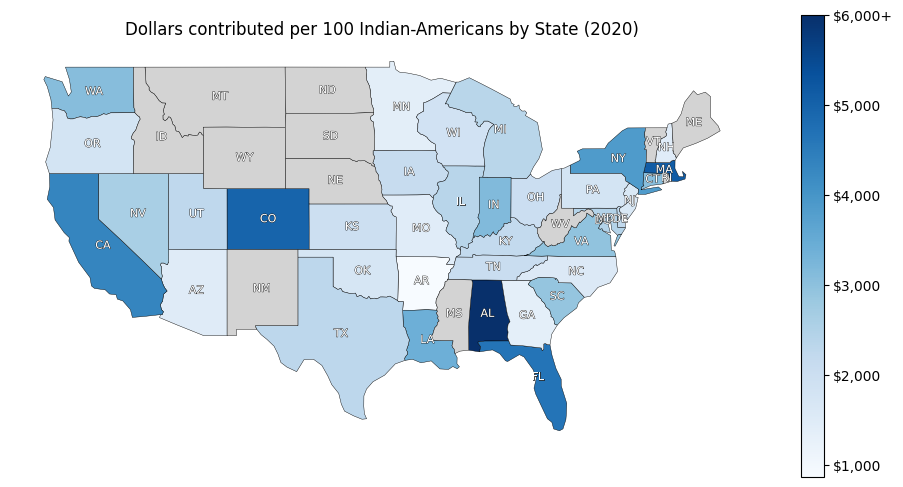

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_df.copy()
copy_df.loc[copy_df['Indian Pop'] < 10000, 'sum_pc_indian'] = np.nan

map = copy_df.plot(
    column="sum_pc_indian",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=6000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"${int(tick):,}" if tick != 6000 else "$6,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Dollars contributed per 100 Indian-Americans by State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

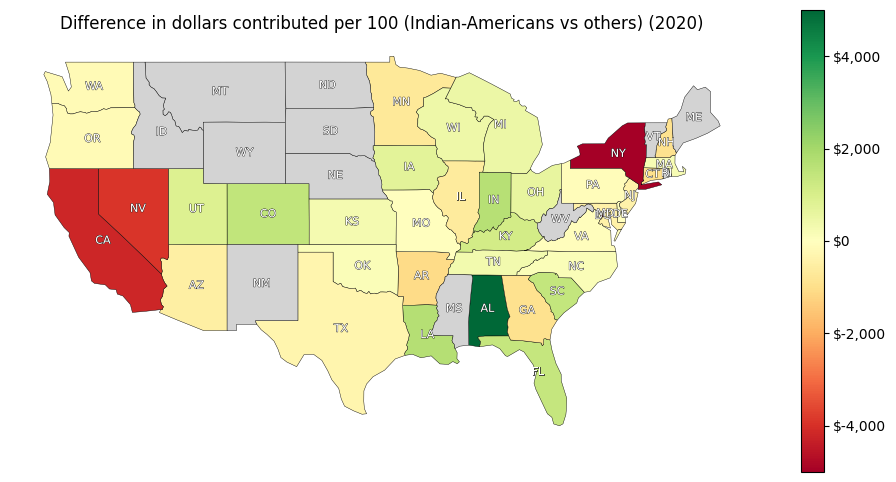

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_df.copy()
copy_df.loc[copy_df['Indian Pop'] < 10000, 'sum_pc_diff'] = np.nan

map = copy_df.plot(
    column="sum_pc_diff",
    cmap="RdYlGn",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=-5000,
    vmax=5000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"${int(tick):,}" if tick != 6000 else "$6,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Difference in dollars contributed per 100 (Indian-Americans vs others) (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [26]:
'''fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

map1 = state_df.plot(
    column="mean_other",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=5000
)

map2 = state_df.plot(
    column="mean_indian",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=5000
)

for map in [map1, map2]:
    cbar = map.get_figure().get_axes()[1]
    ticks = cbar.get_yticks()
    tick_labels = [f"${int(tick):,}" if tick != 5000 else "$5,000+" for tick in ticks]
    cbar.set_yticklabels(tick_labels)

for ax in [ax1, ax2]:
    for idx, row in state_df.iterrows():
        centroid = row["geometry"].centroid
        text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, 
                        ha="center", va="center", color="white")
        text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), 
                                path_effects.Normal()])

plt.suptitle(f"Mean Amount Donated by State (20{year})", fontsize=16)
ax1.set_title(f"Other Donors")
ax2.set_title(f"Indian-Americans")
ax.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")

plt.tight_layout()
plt.show()'''

'fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))\n\nmap1 = state_df.plot(\n    column="mean_other",\n    cmap="Blues",\n    legend=True,\n    edgecolor="black",\n    linewidth=0.3,\n    ax=ax,\n    missing_kwds={"color": "lightgray"},\n    vmax=5000\n)\n\nmap2 = state_df.plot(\n    column="mean_indian",\n    cmap="Blues",\n    legend=True,\n    edgecolor="black",\n    linewidth=0.3,\n    ax=ax,\n    missing_kwds={"color": "lightgray"},\n    vmax=5000\n)\n\nfor map in [map1, map2]:\n    cbar = map.get_figure().get_axes()[1]\n    ticks = cbar.get_yticks()\n    tick_labels = [f"${int(tick):,}" if tick != 5000 else "$5,000+" for tick in ticks]\n    cbar.set_yticklabels(tick_labels)\n\nfor ax in [ax1, ax2]:\n    for idx, row in state_df.iterrows():\n        centroid = row["geometry"].centroid\n        text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, \n                        ha="center", va="center", color="white")\n        text.set_path_effects([path_effects.Stroke(li

In [27]:
state_sector_stats = (
    donors[donors["cycle"] == 2000 + int(year)].groupby(["state", "sector"])
    .agg(
        total_donations=("total_donated", "sum"),
        mean_other=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == False].mean()),
        mean_indian=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == True].mean()),
        med_other=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == False].median()),
        med_indian=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == True].median()),
        sum_other=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == False].sum()),
        sum_indian=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == True].sum()),
        count_other=("indian", lambda x: (x == False).sum()),
        count_indian=("indian", lambda x: (x == True).sum())
    )
    .sort_values("total_donations", ascending=False)
    .reset_index()
)
state_sector_stats.head(10)

,state,sector,total_donations,mean_other,mean_indian,med_other,med_indian,sum_other,sum_indian,count_other,count_indian
0,CA,Unknown,1.371112e+09,15068.237414,1643.324324,250.0,500.0,1.368437e+09,2675332.0,90816,1628
1,NY,Party,1.329065e+09,38191.183253,3957.552239,1000.0,1000.0,1.325883e+09,3181872.0,34717,804
2,CA,Party,7.317845e+08,9398.008630,3210.693667,1000.0,1000.0,7.252443e+08,6540183.0,77170,2037
3,CA,Finance,3.111883e+08,9628.636893,18218.470765,550.0,1000.0,2.990366e+08,12151720.0,31057,667
4,NY,Finance,2.928877e+08,13257.968216,9807.442940,975.0,1000.0,2.878172e+08,5070448.0,21709,517
5,CA,Tech,1.811765e+08,6580.945352,2103.925561,443.0,500.0,1.788306e+08,2345877.0,27174,1115
6,FL,Finance,1.459038e+08,9649.044599,2497.608333,500.0,500.0,1.456041e+08,299713.0,15090,120
7,TX,Party,1.430613e+08,4390.243667,3342.906716,1000.0,1000.0,1.403737e+08,2687697.0,31974,804
8,CA,Ideology/Single Issue,1.410334e+08,2105.201351,1805.189723,319.0,336.0,1.396633e+08,1370139.0,66342,759
9,TX,Finance,1.227747e+08,5750.054349,2561.018727,570.0,625.0,1.220909e+08,683792.0,21233,267


In [28]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
state_sector_df = gdf.merge(state_sector_stats, on="state", how="left")
state_sector_df = state_sector_df.merge(population[population["Year"] == 2020], left_on="state", right_on="Code", how="left")
state_sector_df.iloc[:2]

,iso_3166_2,name,geometry,state,sector,total_donations,mean_other,mean_indian,med_other,med_indian,sum_other,sum_indian,count_other,count_indian,Year,Name,Code,Indian Pop,Census Pop,Share
0,US-MN,Minnesota,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",MN,Party,24374414.0,3187.550776,1718.710843,1000.0,900.0,24231761.0,142653.0,7602,83,2020,Minnesota,MN,45092,5710735,0.789601
1,US-MN,Minnesota,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",MN,Finance,16101552.0,4056.863062,1271.085714,500.0,250.0,16057064.0,44488.0,3958,35,2020,Minnesota,MN,45092,5710735,0.789601


In [29]:
sum_highest_other = state_sector_df[~state_sector_df["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"])].sort_values(by="sum_other", ascending=False).drop_duplicates(subset='state', keep='first')
sum_highest_indian = state_sector_df[~state_sector_df["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"])].sort_values(by="sum_indian", ascending=False).drop_duplicates(subset='state', keep='first')
count_highest_other = state_sector_df[~state_sector_df["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"])].sort_values(by="count_other", ascending=False).drop_duplicates(subset='state', keep='first')
count_highest_indian = state_sector_df[~state_sector_df["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"])].sort_values(by="count_indian", ascending=False).drop_duplicates(subset='state', keep='first')

In [30]:
color_map = dict(zip(sum_highest_other["sector"], plt.cm.Set3(np.linspace(0, 1, len(sum_highest_other["sector"])))))
color_map["Tech"] = np.array([0.6, 0.5, 0.8, 1])
color_map["Defense"] = np.array([0.55, 0.75, 0.8, 1])
color_map["Health"] = np.array([0.8, 0.5, 0.8, 1])
color_map["Finance"] = np.array([0.6, 0.8, 0.6, 1])
color_map["Agribusiness"] = np.array([0.8, 0.8, 0.4, 1])
color_map["Law"] = np.array([0.55, 0.75, 0.9, 1])
color_map["Transportation"] = np.array([0.9, 0.7, 0.1, 1])
color_map["Manufacturing"] = np.array([1.0, 0.5, 0.5, 1])
color_map["Energy"] = np.array([0.7, 0.87, 0.41, 1])
color_map["Labor"] = np.array([0.5, 0.8, 0.9, 1])
color_map["Construction"] = np.array([0.8, 0.8, 0.8, 1])
color_map["Education"] = np.array([0.9, 0.4, 0.6, 1])

In [31]:
color_map

{'Finance': array([0.6, 0.8, 0.6, 1. ]),
 'Health': array([0.8, 0.5, 0.8, 1. ]),
 'Law': array([0.55, 0.75, 0.9 , 1.  ]),
 'Energy': array([0.7 , 0.87, 0.41, 1.  ]),
 'Transportation': array([0.9, 0.7, 0.1, 1. ]),
 'Tech': array([0.6, 0.5, 0.8, 1. ]),
 'Manufacturing': array([1. , 0.5, 0.5, 1. ]),
 'Defense': array([0.55, 0.75, 0.8 , 1.  ]),
 'Agribusiness': array([0.8, 0.8, 0.4, 1. ]),
 'Labor': array([0.5, 0.8, 0.9, 1. ]),
 'Construction': array([0.8, 0.8, 0.8, 1. ]),
 'Education': array([0.9, 0.4, 0.6, 1. ])}

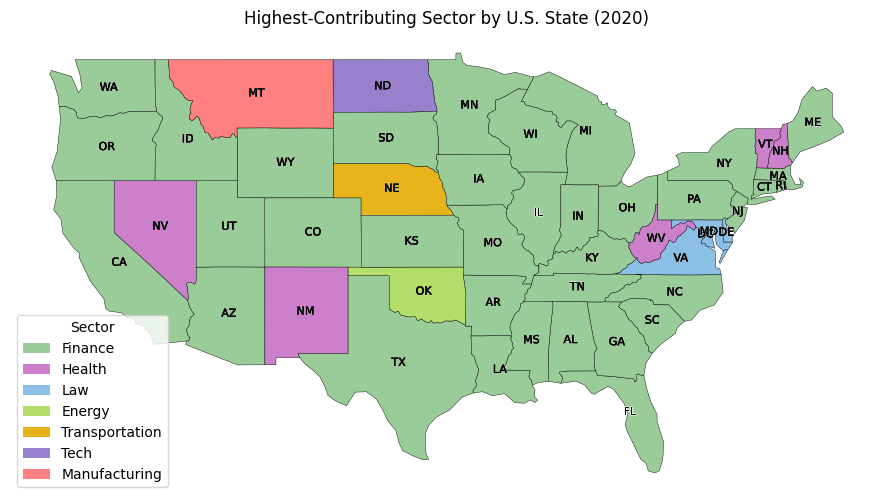

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))

sum_highest_other.plot(
    column="sector",
    color=[color_map[s] for s in sum_highest_other['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in sum_highest_other["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in state_sector_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Highest-Contributing Sector by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

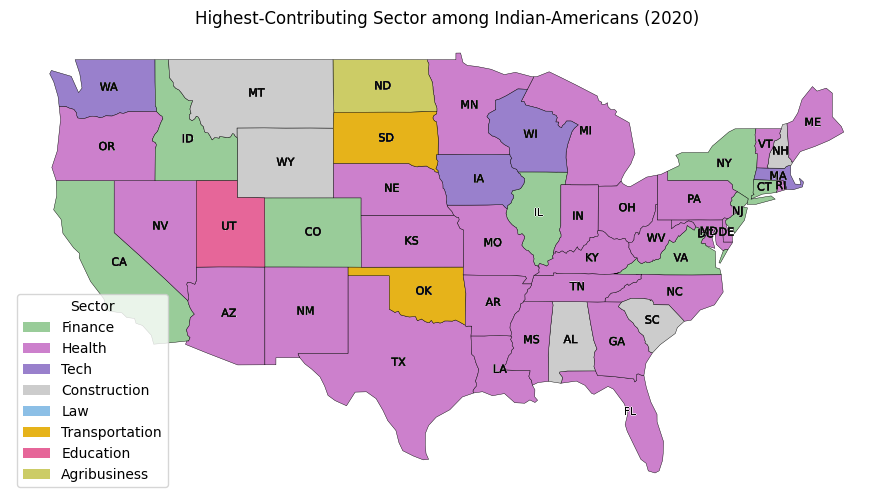

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))

sum_highest_indian.plot(
    column="sector",
    color=[color_map[s] for s in sum_highest_indian['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in sum_highest_indian["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in state_sector_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Highest-Contributing Sector among Indian-Americans (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

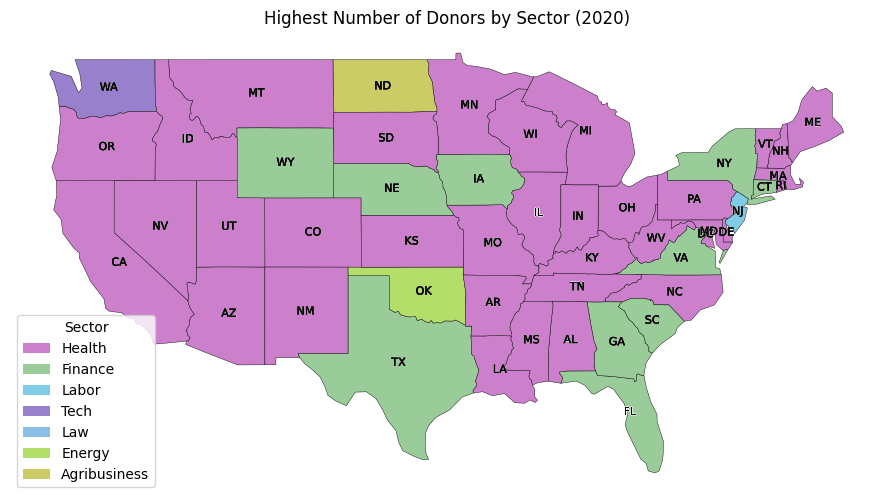

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))

count_highest_other.plot(
    column="sector",
    color=[color_map[s] for s in count_highest_other['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in count_highest_other["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in state_sector_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Highest Number of Donors by Sector (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

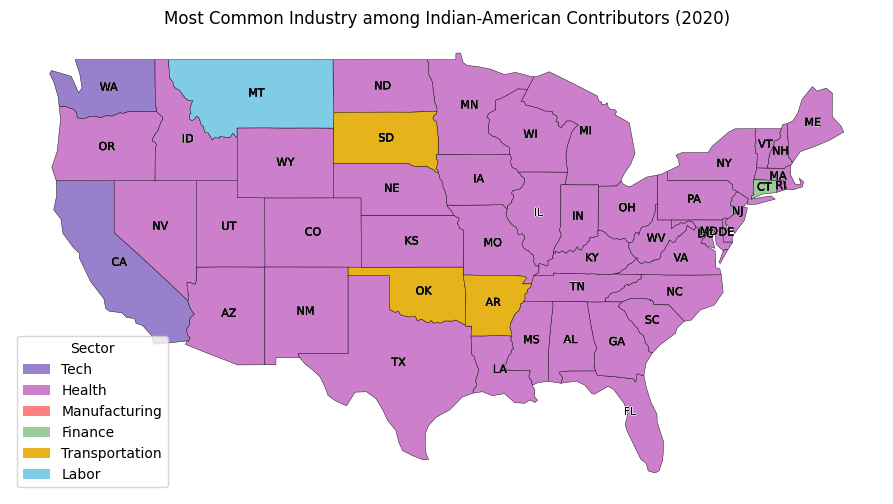

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))

count_highest_indian.plot(
    column="sector",
    color=[color_map[s] for s in count_highest_indian['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in count_highest_indian["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in state_sector_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Most Common Industry among Indian-American Contributors (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [36]:
donors[(donors["indian"] == True) & (~donors["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"]))]["sector"].value_counts() / donors[(donors["indian"] == True) & (~donors["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"]))]["sector"].value_counts().sum() * 100

sector
Health            41.483928
Finance           17.091502
Tech              11.641517
Transportation     8.717134
Law                5.755131
Construction       3.322326
Energy             2.531455
Education          2.474606
Manufacturing      2.182001
Media              1.366049
Labor              1.224763
Defense            1.135309
Agribusiness       1.074280
Name: count, dtype: float64

In [39]:
sum_highest_indian["sector"].value_counts()

sector
Health            27
Finance            8
Construction       5
Tech               4
Transportation     2
Law                1
Education          1
Agribusiness       1
Name: count, dtype: int64

In [38]:
donors[donors["name_new"] == "sant chatwal"]

,contrib_id,name_new,orgname,realcode,gender,occupation,city,state,total_donated,donation_count,avg_donation,med_donation,combined_ratio,indian,cycle,sector
1527713,b0060730635,sant chatwal,Regency Restaurant,G2900,N,SELF,MANHATTAN,NY,4000.0,3,1333.333333,1000.0,25.290693,True,2004,NaN
2727699,b0060730635,sant chatwal,Broadway Regency Restaurant,G2900,N,OWNER,NEW YORK,NY,2000.0,2,1000.000000,1000.0,25.290693,True,2006,NaN
3486214,b0060730635,sant chatwal,Hampshire Hotels & Resorts,T9100,N,CONSULTANT,NEW YORK,NY,4600.0,2,2300.000000,2300.0,25.290693,True,2008,Transportation
4719548,b0060730635,sant chatwal,Hampshire Hotels & Resorts,T9100,N,PRESIDENT & CEO,NEW YORK,NY,11900.0,5,2380.000000,2400.0,25.290693,True,2010,Transportation
5548894,b0060730635,sant chatwal,Hampshire Hotels & Resorts,T9100,N,CEO,NEW YORK,NY,18500.0,7,2642.857143,2500.0,25.290693,True,2012,Transportation
